In [1]:
import datetime
import requests
import io
import pandas as pd
import holidays

import matplotlib.pyplot as plt
%matplotlib inline 

# Functions

In [2]:
def select_time(df, start_time_hour=6, end_time_hour=12):
    df['HOUR'] = pd.to_datetime(df['TIME']).dt.hour
    df_time_frame = df[df["HOUR"].isin(list(range(start_time_hour, end_time_hour + 1)))]
    
    assert len(
        df_time_frame["HOUR"]
        .value_counts()
        .index
        .isin(list(range(start_time_hour, end_time_hour + 1)))
    ) == (end_time_hour + 1 ) - (start_time_hour)
    
    return df_time_frame


def get_daily_entry_counts(row, max_counter):
    counter = row["ENTRIES"] - row["LAST_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["LAST_ENTRIES"])
        counter = min(row["ENTRIES"], row["LAST_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


def get_daily_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["LAST_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["LAST_EXITS"])
        counter = min(row["EXITS"], row["LAST_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# Get Data

In [3]:
##### SET START DATE | http://web.mta.info/developers/turnstile.html
date_val = datetime.date(2018, 9, 1)

dfs = []

##### SET RANGE for number of weeks of data needed
for x in range(1):
    
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    date_val_str = date_val.strftime("%y%m%d") # convert datetime format to string
    
    # create url from pieces above
    full_url = url.format(date_val_str)
    
    # Get data from url
    r = requests.get(full_url)
    r.raise_for_status()
    
    # Create dataframe
    r_content = r.content
    df_mta_data = pd.read_csv(io.StringIO(r_content.decode('utf-8')))
    dfs.append(df_mta_data)
    
    # Keep header if it's the first one, otherwise remove header and append to csv directly
    #if x == 0:
    #    df_mta_data.to_csv(output_file_loc, index = False, header = True)
            
    #else:
    #    with open(output_file_loc, 'a') as f:
    #        df_mta_data.to_csv(output_file_loc, mode = 'a', header = False, index = False)

    # Add 7 days to the date         
    date_val = date_val + datetime.timedelta(days = 7)
    
    # Just to make sure it's running smoothly
    print("Done with: " + full_url)
    print(x)
    
df = pd.concat(dfs)
print("yass done done done!!")    

Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180901.txt
0
yass done done done!!


# Clean Data

In [4]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384


In [5]:
#clean up the columns
df.columns = [col.strip() for col in df.columns]

In [6]:
#Clean up the columns
df.columns = [col.strip() for col in df.columns]

#Add datetime column
df['DATE_TIME'] = df['DATE'] + " " + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

#Add Day of Week
df['DAY_OF_WEEK'] = (df['DATE_TIME']
                     .dt.dayofweek.map({0: "Monday", 
                                        1: "Tuesday", 
                                        2: "Wednesday", 
                                        3: "Thursday", 
                                        4: "Friday", 
                                        5: "Saturday", 
                                        6:"Sunday"}))

#Add Month
df['MONTH'] = (pd.DatetimeIndex(df['DATE_TIME'])
               .month.map({1:'January', 
                        2: 'February',
                        3: 'March',
                        4: 'April',
                        5: 'May',
                        6: 'June',
                        7: 'July', 
                        8: 'August', 
                        9: 'Septemner', 
                        10: 'October', 
                        11: 'November', 
                        12: 'December'}))

#Add Year
df['YEAR'] = pd.DatetimeIndex(df['DATE_TIME']).year

#Add Holiday
us_holidays = holidays.UnitedStates(years = [2018, 2019])
df['HOLIDAY'] = pd.to_datetime(df['DATE']).isin(us_holidays)

In [7]:
#Get rid of duplicates
df = df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])

In [8]:
#Sanity check that dupes are removed
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-08-25 00:00:00,1
131814,R147,R033,04-00-06,TIMES SQ-42 ST,2018-08-27 04:00:00,1
131744,R147,R033,04-00-04,TIMES SQ-42 ST,2018-08-29 08:00:00,1
131745,R147,R033,04-00-04,TIMES SQ-42 ST,2018-08-29 12:00:00,1
131746,R147,R033,04-00-04,TIMES SQ-42 ST,2018-08-29 16:00:00,1


# Filter Data & Sum Entries

In [9]:
# df_morn containing only morning data for each turnstile
df_morn = select_time(df)

# sort values
df_morn.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=True)
# create column for merging
df_morn['for_merging'] = df['C/A'] + "_" + df['UNIT'] + "_" + df['SCP'] + "_" + df['STATION'] + "_" + df['DATE']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
# dataframe containing earliest turnstile log for each day
df_first = (df_morn
            .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
            .head(1))

# dataframe containing latest turnstile log for each day
df_last = (df_morn
           .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
           .tail(1)[['ENTRIES', 'EXITS', 'TIME', 'for_merging']]).rename(columns={'ENTRIES': 'LAST_ENTRIES', 'EXITS': 'LAST_EXITS', 'TIME': 'LAST_TIME'})

# merge
df_daily = pd.merge(df_first, df_last, on = 'for_merging', how = 'left')

In [23]:
# Calculate Daily Entries per Turnstile
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_entry_counts, axis=1, max_counter=1000000)

# Calculate Daily Exits per Turnstile
df_daily["DAILY_EXITS"] = df_daily.apply(get_daily_exit_counts, axis=1, max_counter=1000000)

# Calculate Total Entries & Exits per Turnstile
df_daily['DAILY_TOTAL'] = df_daily['DAILY_ENTRIES'] + df_daily['DAILY_EXITS']

1097772 5091
1281225 319


In [24]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,YEAR,HOLIDAY,HOUR,for_merging,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,...,2018,False,8,A002_R051_02-00-00_59 ST_08/25/2018,6736180,2283314,12:00:00,75,85,160
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2018,08:00:00,REGULAR,6736705,...,2018,False,8,A002_R051_02-00-00_59 ST_08/26/2018,6736746,2283524,12:00:00,41,41,82
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2018,08:00:00,REGULAR,6737169,...,2018,False,8,A002_R051_02-00-00_59 ST_08/27/2018,6737301,2283965,12:00:00,132,229,361
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2018,08:00:00,REGULAR,6738474,...,2018,False,8,A002_R051_02-00-00_59 ST_08/28/2018,6738621,2284402,12:00:00,147,186,333
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/29/2018,08:00:00,REGULAR,6739847,...,2018,False,8,A002_R051_02-00-00_59 ST_08/29/2018,6739986,2284838,12:00:00,139,238,377


In [27]:
# Clean up df_daily
cols = ['C/A', 
        'UNIT', 
        'SCP', 
        'STATION', 
        'DATE',
        'TIME',
        'DESC',
        'DAY_OF_WEEK', 
        'MONTH', 
        'YEAR', 
        'HOLIDAY', 
        'ENTRIES', 
        'EXITS', 
        'LAST_ENTRIES', 
        'LAST_EXITS',
        'LAST_TIME', 
        'DAILY_ENTRIES', 
        'DAILY_EXITS', 
        'DAILY_TOTAL']

df_daily_clean = df_daily[cols]
df_daily_clean.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
0,A002,R051,02-00-00,59 ST,08/25/2018,08:00:00,REGULAR,Saturday,August,2018,False,6736105,2283229,6736180,2283314,12:00:00,75,85,160
1,A002,R051,02-00-00,59 ST,08/26/2018,08:00:00,REGULAR,Sunday,August,2018,False,6736705,2283483,6736746,2283524,12:00:00,41,41,82
2,A002,R051,02-00-00,59 ST,08/27/2018,08:00:00,REGULAR,Monday,August,2018,False,6737169,2283736,6737301,2283965,12:00:00,132,229,361
3,A002,R051,02-00-00,59 ST,08/28/2018,08:00:00,REGULAR,Tuesday,August,2018,False,6738474,2284216,6738621,2284402,12:00:00,147,186,333
4,A002,R051,02-00-00,59 ST,08/29/2018,08:00:00,REGULAR,Wednesday,August,2018,False,6739847,2284600,6739986,2284838,12:00:00,139,238,377


# Starting to find outliers

Still working...

In [33]:
df_daily_clean[df_daily_clean['DESC'] == 'RECOVR AUD']

,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
495,A022,R022,01-00-00,34 ST-HERALD SQ,08/30/2018,08:00:00,RECOVR AUD,Thursday,August,2018,False,25727644,10533500,25728199,10534716,12:00:00,555,1216,1771
502,A022,R022,01-00-01,34 ST-HERALD SQ,08/30/2018,08:00:00,RECOVR AUD,Thursday,August,2018,False,25902114,10475046,25902577,10476079,12:00:00,463,1033,1496
509,A022,R022,01-00-02,34 ST-HERALD SQ,08/30/2018,08:00:00,RECOVR AUD,Thursday,August,2018,False,13713113,5382701,13713729,5383523,12:00:00,616,822,1438
516,A022,R022,01-06-00,34 ST-HERALD SQ,08/30/2018,08:00:00,RECOVR AUD,Thursday,August,2018,False,67511619,17951490,67511686,17952085,12:00:00,67,595,662
523,A022,R022,01-06-01,34 ST-HERALD SQ,08/30/2018,08:00:00,RECOVR AUD,Thursday,August,2018,False,5034199,7736936,5034226,7737708,12:00:00,27,772,799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29604,R525,R018,02-06-00,74 ST-BROADWAY,08/31/2018,08:00:00,RECOVR AUD,Friday,August,2018,False,168207,2133433,168223,2133540,12:00:00,16,107,123
29611,R525,R018,02-06-01,74 ST-BROADWAY,08/31/2018,08:00:00,RECOVR AUD,Friday,August,2018,False,48528,3253873,48531,3254074,12:00:00,3,201,204
31793,R636,R209,00-00-00,STERLING ST,08/29/2018,08:00:00,RECOVR AUD,Wednesday,August,2018,False,10569852,4888836,10570653,4888925,12:00:00,801,89,890
31800,R636,R209,00-00-01,STERLING ST,08/29/2018,08:00:00,RECOVR AUD,Wednesday,August,2018,False,4327778,2728614,4328409,2728709,12:00:00,631,95,726


In [32]:
df_daily_clean[df_daily["DAILY_ENTRIES"] > 5000]

#mask = ((df_daily['STATION'] == 'JOURNAL SQUARE') & (df_daily['DATE'] == '08/29/2018'))
#df_daily[df_daily[mask]
         
#df_daily[mask].sort_values(by = 'TIME')
#df_daily[df_daily["DAILY_ENTRIES"] > 5000]

,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
18257,PTH03,R552,00-00-09,JOURNAL SQUARE,08/29/2018,08:29:46,REGULAR,Wednesday,August,2018,False,1097772,960528,5091,2023,12:42:12,5091,958505,963596
18520,PTH05,R543,00-00-05,EXCHANGE PLACE,08/30/2018,07:14:10,REGULAR,Thursday,August,2018,False,419044,1281225,2,319,11:22:19,419042,319,419361
18983,PTH11,R545,00-00-03,14TH STREET,08/29/2018,06:27:28,REGULAR,Wednesday,August,2018,False,17106,853,17,2,10:39:37,17089,851,17940
19675,PTH19,R549,02-01-01,NEWARK C,08/31/2018,06:30:48,REGULAR,Friday,August,2018,False,30631,1995,114,1,10:43:25,30517,1994,32511


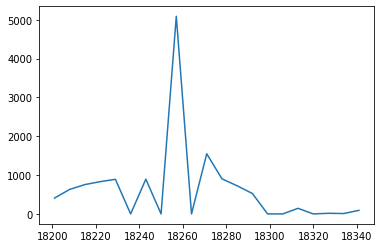

In [28]:
mask = ((df_daily_clean['STATION'] == 'JOURNAL SQUARE') & (df_daily['DATE'] == '08/29/2018'))
plt.plot(df_daily_clean['DAILY_ENTRIES'][mask])

#plt.plot(df_daily['DAILY_ENTRIES'][(df_daily['DAILY_ENTRIES'] < 5000) & (df)])

In [ ]:
df_daily["DAILY_EXITS"] = df_daily.apply(get_daily_exit_counts, axis=1, max_counter=1000000)

In [ ]:
plt.plot(df_daily['DAILY_EXITS'][df_daily['DAILY_EXITS'] < 3500])

# Analysis

Still working...

In [ ]:
#df_daily.groupby(['STATION', 'LINENAME', 'DATE'])['DAILY_ENTRIES', 'DAILY_EXITS'].sum().reset_index()
df_daily.groupby(['DAY_OF_WEEK'])['DAILY_ENTRIES', 'DAILY_EXITS'].sum().reset_index().sort_values(by = 'DAILY_ENTRIES')